### SOS - Shridhar Patil Final Assignment

#### Problem 1:


Construct the Hamiltonian for the $H_2$ molecule:

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp, Pauli

H_paulis = ["II","IZ","ZI","ZZ","XX"]
H_coeff = [-1.052,0.398,-0.398,-0.011,0.181]

H = SparsePauliOp(H_paulis,H_coeff) #Hamiltonian generated

print(H)

SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ', 'XX'],
              coeffs=[-1.052+0.j,  0.398+0.j, -0.398+0.j, -0.011+0.j,  0.181+0.j])


#### Problem 2:
Note: I have used an older version of Qiskit (Qiskit 1.0.0) since I was having some import errors with latest version.

In [2]:
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms.optimizers import SPSA
from qiskit.primitives import Estimator
import numpy as np

ansatz = TwoLocal(num_qubits=2, rotation_blocks='ry', entanglement_blocks='cx', entanglement='full', reps=2)

optimiser_Hamil = SPSA(maxiter=150)

initial_point = np.random.uniform(-np.pi, np.pi, ansatz.num_parameters)

estimator = Estimator() #Estimator primitive 

#make cost function
def cost_function(params):
    job = estimator.run([ansatz], [H], [params])
    return job.result().values[0]

result = optimiser_Hamil.minimize(
    fun=cost_function,
    x0=initial_point
)

ideal_E = result.fun

print(f"Ideal Ground state energy: {ideal_E:.6f}")

Ideal Ground state energy: -1.857304


Hence the final Ground state energy is reported (in ideal simulation).

In [3]:
from qiskit_aer.noise import NoiseModel, pauli_error
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Estimator as withNoiseEstimator


bit_flip_error = pauli_error([('X', 0.05), ('I', 0.95)]) #0.05 chance of the bitflip pauli X error. 

bit_flip_error = bit_flip_error.tensor(bit_flip_error) #make it 2 qubit error gate

model_noise = NoiseModel()
model_noise.add_all_qubit_quantum_error(bit_flip_error, ['cx'])

simulator = AerSimulator(noise_model=model_noise)

estimator = withNoiseEstimator()
estimator.set_options(backend=simulator, shots=10000)


def cost_function(params):
    job = estimator.run([ansatz], [H], [params])
    return job.result().values[0]

optimizer = SPSA(maxiter=150)
initial_point = np.random.uniform(-np.pi, np.pi, ansatz.num_parameters)

result = optimizer.minimize(
    fun=cost_function,
    x0=initial_point
)

Noisy_E = result.fun

print(f"Noisy ground state energy: {Noisy_E:.6f}")

Noisy ground state energy: -1.854584


We see that noisy energy is slightly more than the ideal measurement energy. We can say this bcz the energy expectation value is not minimised perfectly in noisy condition because of bit flip errors (in our VQE algor.), hence the noisy condition has *more* ground state energy than *ideal* state.

#### Problem 3:

We make 3 functions for each of the three main parts of the code: encode some aribtrary logical state $\vert \psi \rangle$ into three qubits, then measure the syndrome after some noise and apply corrections.

In [4]:
def encode_logic_state_to_physical_state(qc: QuantumCircuit, logical_reg: QuantumRegister, physical_reg: QuantumRegister):

#pass the circuit, logical_reg with state vector and the physical_reg which is quantum register of physical qubits in qc

    qc.cx(logical_reg[0], physical_reg[0])
    qc.cx(physical_reg[0], physical_reg[1])
    qc.cx(physical_reg[1], physical_reg[2]) #kinda exactly like forming a GHZ state: all qubits have same form.
    qc.barrier()

def measure_the_syndrome(qc: QuantumCircuit, physical_reg: QuantumRegister, ancilla: QuantumRegister, syndrome: ClassicalRegister):

#ancilla is passed 2 qubit register. physical_reg is the reg of 3 qubits in qc. syndrome is 2 bit classical reg of measuremnt outcomes

    #ancilla[0]
    qc.cx(physical_reg[0], ancilla[0])
    qc.cx(physical_reg[1], ancilla[0])

    # ancilla[1]
    qc.cx(physical_reg[1], ancilla[1])
    qc.cx(physical_reg[2], ancilla[1])

    # Measure them to classical reg (syndrome)
    qc.measure(ancilla[0], syndrome[0])
    qc.measure(ancilla[1], syndrome[1])
    qc.barrier()

def correct_the_errors(qc: QuantumCircuit, physical_reg: QuantumRegister, syndrome: ClassicalRegister):
    #apply corrections to the measured syndromes

    qc.x(physical_reg[0]).c_if(syndrome, 0b10) #qubit 0 error
    qc.x(physical_reg[1]).c_if(syndrome, 0b11) #qubit 1 error
    qc.x(physical_reg[2]).c_if(syndrome, 0b01) # qubit 2 error
    qc.barrier()

def decode_bit_flip(qc, logical_reg):
    # Undo the encoding back to logical_reg
    qc.cx(logical_reg[0], logical_reg[2])
    qc.cx(logical_reg[0], logical_reg[1])


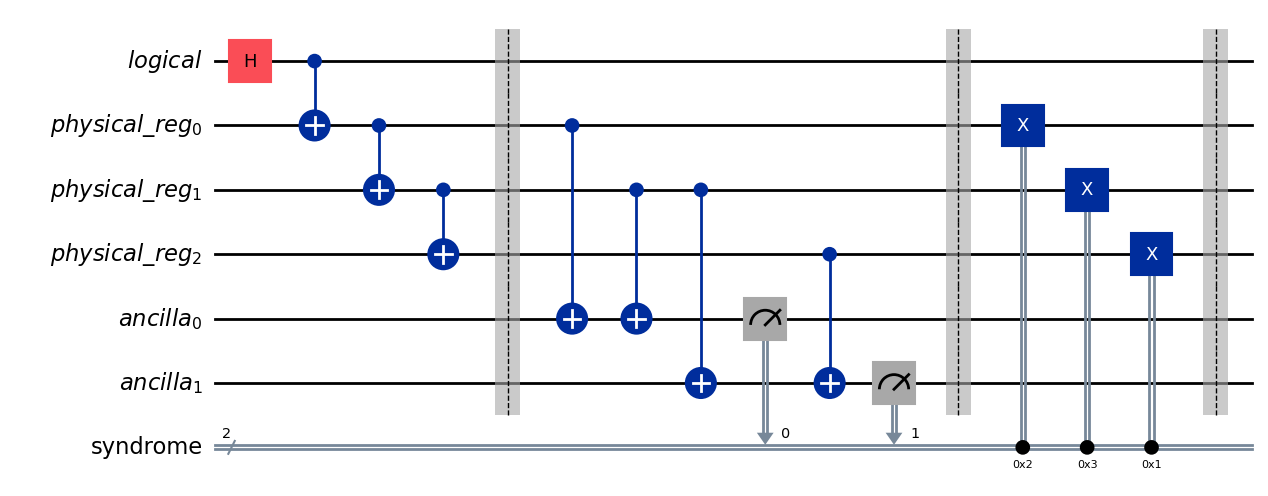

In [5]:
physical_reg = QuantumRegister(3, 'physical_reg')
logical = QuantumRegister(1, 'logical')

ancilla = QuantumRegister(2, 'ancilla')
syndrome = ClassicalRegister(2, 'syndrome')

qc = QuantumCircuit(logical, physical_reg, ancilla, syndrome)

# Prepare some arbitrary state qubit
qc.h(logical[0])

encode_logic_state_to_physical_state(qc, logical, physical_reg)

#We can apply some noise on the circuit here for the realistic testing purposes
measure_the_syndrome(qc, physical_reg, ancilla, syndrome)

correct_the_errors(qc, physical_reg, syndrome)

qc.draw('mpl', fold = -1)


#### Problem 4:
So we again calculating ground state energy of $H_2$ but with noise model (as before), and error correction at each step, following 3 qubit logical qubit implementation.

-1.065828125


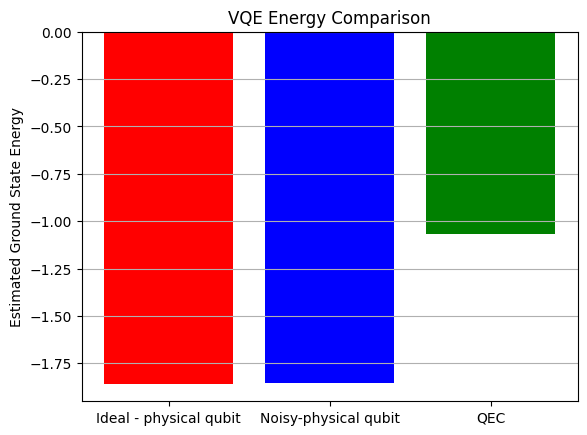

In [17]:
import matplotlib.pyplot as plt


estimator = Estimator()

def make_qec_protected_ansatz():
    q = QuantumRegister(5, "q")  
    qc = QuantumCircuit(q)

    #make the logical qubit
    qc.cx(q[0], q[1])
    qc.cx(q[0], q[2])

    #ansatz on logical qubit (q[0])
    theta = Parameter("θ")
    qc.ry(theta, q[0])

    qc.cx(q[0], q[1])
    qc.cx(q[0], q[2])

    # take extraction
    qc.cx(q[0], q[3])
    qc.cx(q[1], q[3])
    qc.cx(q[1], q[4])
    qc.cx(q[2], q[4])

    # correction
    qc.x(q[0])
    qc.x(q[1])
    qc.x(q[2])

    return qc, [theta]

def extend_hamiltonian(H, total_qubits): 
    extended_paulis = []
    for pauli, coeff in zip(H.paulis, H.coeffs):
        padded_label = pauli.to_label().ljust(total_qubits, 'I')
        extended_paulis.append((padded_label, coeff))
    return SparsePauliOp.from_list(extended_paulis)

H_qec = extend_hamiltonian(H, total_qubits=5)

def cost_function_protected(theta):
    qc, params = make_qec_protected_ansatz()
    qc = qc.assign_parameters({params[0]: theta[0]})
    return estimator.run(qc, H_qec).result().values[0]

opt = SPSA(maxiter=150)

initial_point_unprot = np.random.uniform(-np.pi, np.pi, 4)
initial_point_qec = np.random.uniform(-np.pi, np.pi, 1)
res_qec = opt.minimize(cost_function_protected, initial_point_qec)

Noisy_corrected_E = res_qec.fun

print(Noisy_corrected_E)
plt.bar(["Ideal - physical qubit", "Noisy-physical qubit", "QEC"],
        [ideal_E, Noisy_E, Noisy_corrected_E],
        color=["red", "blue", "green"])
plt.ylabel("Estimated Ground State Energy")
plt.title("VQE Energy Comparison")
plt.grid(True, axis='y')
plt.show()
